# install & import

In [1]:
conda install -c conda-forge xgboost

Retrieving notices: ...working... ERROR conda.notices.fetch:get_channel_notice_response(63): Request error <HTTPSConnectionPool(host='repo.anaconda.com', port=443): Max retries exceeded with url: /pkgs/r/notices.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fc6191ed490>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))> for channel: defaults url: https://repo.anaconda.com/pkgs/r/notices.json
ERROR conda.notices.fetch:get_channel_notice_response(63): Request error <HTTPSConnectionPool(host='conda.anaconda.org', port=443): Max retries exceeded with url: /conda-forge/notices.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fc6191ed790>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))> for channel: conda-forge url: https://conda.anaconda.org/conda-forge/notices.json
ERROR conda.notices.fetch:get_channel_notice_response(63)

In [2]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [3]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model evaluation und visualisation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, fbeta_score

from sklearn.model_selection import GridSearchCV

import os
import pandas as pd
import numpy as np

#for oversampling
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

np.random.seed(42)

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load and investigate data

In [4]:
data=pd.read_csv('/Users/andrew.tseng/Desktop/masterclass/project/0318.csv')

In [5]:
data.head()

,distance,product_size_cm3,product_weight_g,product_category_subdivide,tardy,Month_name,number_order_in_process,tardy_proportion_last_10_orders
0,687.431565,61920,11800,Home Appliances,False,September,1,0.0
1,716.237761,61920,11800,Home Appliances,False,October,1,0.0
2,411.866870,61920,11800,Home Appliances,False,October,1,0.0
3,1736.921636,24080,8875,Home and Gardon,False,February,1,0.0
4,523.465569,24080,8875,Home and Gardon,False,February,1,0.0


In [6]:
# Investigate data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94613 entries, 0 to 94612
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   distance                         94613 non-null  float64
 1   product_size_cm3                 94613 non-null  int64  
 2   product_weight_g                 94613 non-null  int64  
 3   product_category_subdivide       94613 non-null  object 
 4   tardy                            94613 non-null  bool   
 5   Month_name                       94613 non-null  object 
 6   number_order_in_process          94613 non-null  int64  
 7   tardy_proportion_last_10_orders  94613 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 5.1+ MB


In [7]:
cat = ['product_category_subdivide','tardy','Month_name'] 
       # can be automated
for c in cat:
    print( c, ':')
    print(data[c].value_counts() )

product_category_subdivide :
Home and Gardon                                 25756
Electronics and Gadgets                         19876
Beauty and Personal Care                        11639
Sports and Outdoors                              7499
Fashion, Apparel and Luggage                     6794
Baby and Toys                                    6526
Business, Industrial and Scientific Supplies     5814
Automotive and Parts                             3783
Home Appliances                                  1891
Pet                                              1664
Books and Media                                  1306
Food and Beverages                                946
Musical Instruments                               606
Arts and Crafts                                   213
Decoration                                        163
Network and Security Service                      137
Name: product_category_subdivide, dtype: int64
tardy :
False    86960
True      7653
Name: tardy, dtype: in

In [8]:
# We can investigate the numerals using the "describe" function
data.describe()

,distance,product_size_cm3,product_weight_g,number_order_in_process,tardy_proportion_last_10_orders
count,94613.000000,94613.000000,94613.000000,94613.000000,94613.000000
mean,601.637344,15228.659846,2101.887161,25.354159,0.074147
std,595.459153,23355.171907,3750.959136,86.538423,0.119697
min,0.000000,168.000000,2.000000,1.000000,0.000000
25%,186.720780,2816.000000,300.000000,1.000000,0.000000
50%,434.286261,6450.000000,700.000000,2.000000,0.000000
75%,799.117511,18400.000000,1800.000000,8.000000,0.100000
max,8736.947618,296208.000000,40425.000000,911.000000,1.000000


In [9]:
feature_names=data.drop("tardy", axis=1).columns
print(feature_names)

Index(['distance', 'product_size_cm3', 'product_weight_g',
       'product_category_subdivide', 'Month_name', 'number_order_in_process',
       'tardy_proportion_last_10_orders'],
      dtype='object')


# Test-Train split

In [10]:
data_label = data['tardy'].copy()
data_features = data.drop('tardy', axis=1)

data_features, data_features_test, data_label, data_label_test \
    = train_test_split(data_features, data_label, test_size=0.2, random_state=42,stratify=data_label)

In [11]:
print(data_features.shape)
print(data_label.shape)
data_features.head()

(75690, 7)
(75690,)


,distance,product_size_cm3,product_weight_g,product_category_subdivide,Month_name,number_order_in_process,tardy_proportion_last_10_orders
17465,581.846048,4096,150,Electronics and Gadgets,April,19,0.70
65781,1738.850412,4807,100,Beauty and Personal Care,April,1,0.20
6551,163.059637,2640,450,Decoration,July,2,0.00
65081,410.870764,7000,550,Sports and Outdoors,January,1,0.00
54220,536.252434,2210,180,Electronics and Gadgets,December,3,0.25


# Pre-process data

In [12]:
# Numerical and categorical features are handled differently, therefore we split them.

# we get the categorical features by removing the deposit from the list of categories (as it's the label)
cat_feature_names = [item for item in cat if not ( item=='tardy' ) ]

data_features_num = data_features.drop(cat_feature_names, axis=1) 
numerical_feature_names = data_features_num.columns

data_features_cat = data_features[cat_feature_names]

In [13]:
cat_feature_names

['product_category_subdivide', 'Month_name']

In [14]:
numerical_feature_names

Index(['distance', 'product_size_cm3', 'product_weight_g',
       'number_order_in_process', 'tardy_proportion_last_10_orders'],
      dtype='object')

In [15]:
# Categorical features can further be divided in Ordinal and OneHotEncoded features.
# The only feature suitable for an ordinal encoder is 'education'. 
# For good results, we need to manually the desired order of the classes
#ordinal_feature_names = ['education']
#ordinal_feature_classes = [['unknown', 'primary', 'secondary', 'tertiary']]

one_hot_feature_names = [item for item in cat_feature_names ]


In [16]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [17]:
# counting missing values for each feature:
for i in data:
    print( i,data[i].isnull().sum() )

distance 0
product_size_cm3 0
product_weight_g 0
product_category_subdivide 0
tardy 0
Month_name 0
number_order_in_process 0
tardy_proportion_last_10_orders 0


In [18]:
# Impute fills missing numerals by the median of the remaining data
#imputer = SimpleImputer(strategy="median")

# The imputer is fit on the training data. It can then also be applied to the test data (without a refit)
#num_pipeline = Pipeline([
    #    ('selector', DataFrameSelector(numerical_feature_names)),
    #    ('imputer', SimpleImputer(strategy="median")),
    #    ('std_scaler', StandardScaler())
   # ])

# We run the pipeline to check, whether it runs with no problems
#temp = num_pipeline.fit_transform(data_features)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# Define a function to apply log transformation with a small constant added
def log_transform(X):
    return np.log(X + 1)

# Define your numerical pipeline with selector, imputer, scaler, and log transformation
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numerical_feature_names)),
        ('imputer', SimpleImputer(strategy="median")),
        ('log_transformer', FunctionTransformer(log_transform)),
        ('std_scaler', StandardScaler())
    ])

# Fit and transform your data using the pipeline
X_log = num_pipeline.fit_transform(data_features)


In [19]:
numerical_feature_names

Index(['distance', 'product_size_cm3', 'product_weight_g',
       'number_order_in_process', 'tardy_proportion_last_10_orders'],
      dtype='object')

In [20]:
# One-Hot-Encoder replaces categorical features by boolean features, stating whether a certain category is true or not
one_hot_pipeline = Pipeline([
        ('selector', DataFrameSelector(one_hot_feature_names)),
        ('one_hot_encoder', OneHotEncoder(sparse=False))
    ])

# We run the pipeline to check, whether it runs with no problems
temp = one_hot_pipeline.fit_transform(data_features)

In [21]:
#Combine both imputers and get cleaned data

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("one_hot_pipeline", one_hot_pipeline),
        
    ])
data_prepared = full_pipeline.fit_transform(data_features)

In [22]:
data_label = data_label.map({True:1, False:0})
data_label_test = data_label_test.map({True:1, False:0})

In [23]:
# Check the size of the data to see the amount of features
print(data_prepared.shape)

(75690, 33)


# Split Train, Validataion data set

In [24]:
### Train-validation-split ###

train_features, validation_features, train_label, validation_label \
    = train_test_split(data_prepared, data_label, test_size=0.2, random_state=42,stratify=data_label)

In [25]:
train_label.head()
train_features.shape

(60552, 33)

In [26]:
train_label.info()
validation_label.info()

<class 'pandas.core.series.Series'>
Int64Index: 60552 entries, 78064 to 13988
Series name: tardy
Non-Null Count  Dtype
--------------  -----
60552 non-null  int64
dtypes: int64(1)
memory usage: 946.1 KB
<class 'pandas.core.series.Series'>
Int64Index: 15138 entries, 44028 to 9368
Series name: tardy
Non-Null Count  Dtype
--------------  -----
15138 non-null  int64
dtypes: int64(1)
memory usage: 236.5 KB


# Oversampling Train Set

In [27]:

# Initialize RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and resample the data
train_features_oversampled, train_label_oversampled = ros.fit_resample(train_features,train_label)

# Check the resampled class distribution
#print(f"Resampled class distribution: {Counter(y_resampled)}")

print('Size after oversampling:')
print(np.shape(train_features_oversampled))

print('Oversampled portion of class 1:')
print(sum(train_label_oversampled)/len(train_label_oversampled))

Size after oversampling:
(111308, 33)
Oversampled portion of class 1:
0.5


# Oversampling Validation Set

In [28]:
#validation_features_oversampled, validation_label_oversampled \
  #  = SMOTE().fit_resample(validation_features,validation_label)

In [29]:
#print('Size after oversampling:')
#print(np.shape(validation_features_oversampled))

In [30]:
#print('Oversampled portion of class 1:')
#print(sum(validation_label_oversampled)/len(validation_label_oversampled))

# Evaluate models

Xgboost

[13:27:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


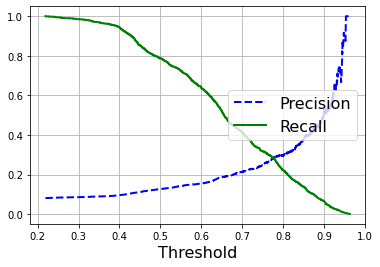

In [31]:

xgb_classifier = xgb.XGBClassifier(max_depth=2,learning_rate=0.1,subsample=0.1,
                                   scale_pos_weight=1.5,random_state=42)
xgb_classifier.fit(train_features_oversampled, train_label_oversampled)

# calculate the predicted probabilities for the test data
y_scores_xg = xgb_classifier.predict_proba(validation_features)[:, 1]

# calculate the precision, recall, and threshold values
precisionxg, recallxg, thresholdxg = precision_recall_curve(validation_label, y_scores_xg)

plt.plot(thresholdxg, precisionxg[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholdxg, recallxg[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)

# save the figure as this results in a better quality compared to a screenshot
plt.savefig('precision_recall.png')
plt.savefig('precision_recall.eps', format='eps', transparent=False)



In [32]:
y_pred_xg = xgb_classifier.predict(validation_features)

accuracy_xg=accuracy_score(validation_label, y_pred_xg)
recall_xg= recall_score(validation_label, y_pred_xg)
precision_xg=precision_score(validation_label, y_pred_xg)

print("XGboost Result:")
print("accuracy:", accuracy_xg)
print("recall:", recall_xg)
print("precision:",precision_xg)

#calculate F1,F2,F0.5
f1 = f1_score(validation_label, y_pred_xg)
f2 = fbeta_score(validation_label, y_pred_xg, beta=2)
f05 = fbeta_score(validation_label, y_pred_xg, beta=0.5)

print("F1 score:",f1)
print("F2 score:",f2)
print("F0.5 score:",f05)

XGboost Result:
accuracy: 0.543004359889021
recall: 0.7867647058823529
precision: 0.12637795275590552
F1 score: 0.21777476255088193
F2 score: 0.3847075743048897
F0.5 score: 0.15187358062074185


In [33]:
#overfitting check
from sklearn import metrics
print('Training Accuracy : ',metrics.accuracy_score(train_label_oversampled,xgb_classifier.predict(train_features_oversampled))*100)
print('Validation Accuracy : ',metrics.accuracy_score(validation_label,xgb_classifier.predict(validation_features))*100)

Training Accuracy :  66.27286448413412
Validation Accuracy :  54.300435988902095


Feature: distance, 0, Score: 0.05111
Feature: product_size_cm3, 1, Score: 0.01933
Feature: product_weight_g, 2, Score: 0.02919
Feature: number_order_in_process, 3, Score: 0.03365
Feature: tardy_proportion_last_10_orders, 4, Score: 0.18499
Feature: Home and Gardon, 5, Score: 0.00000
Feature: Electronics and Gadgets, 6, Score: 0.00000
Feature: Beauty and Personal Care, 7, Score: 0.00000
Feature: Sports and Outdoors, 8, Score: 0.00000
Feature: Fashion, Apparel and Luggage, 9, Score: 0.00000
Feature: Baby and Toys, 10, Score: 0.00000
Feature: Business, Industrial and Scientific Supplies, 11, Score: 0.00000
Feature: Automotive and Parts, 12, Score: 0.00000
Feature: Home Appliances, 13, Score: 0.00000
Feature: Pet, 14, Score: 0.00000
Feature: Books and Media, 15, Score: 0.00000
Feature: Food and Beverages, 16, Score: 0.00307
Feature: Musical Instruments, 17, Score: 0.01330
Feature: Arts and Crafts, 18, Score: 0.00000
Feature: Decoration, 19, Score: 0.00000
Feature: Network and Security Servi

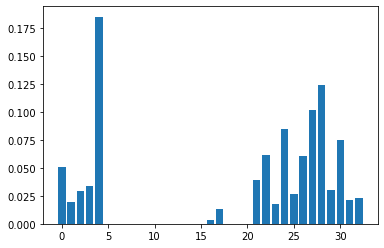

In [34]:
#feature importance
feature_names = ['distance','product_size_cm3','product_weight_g','number_order_in_process','tardy_proportion_last_10_orders','Home and Gardon','Electronics and Gadgets',
                 'Beauty and Personal Care','Sports and Outdoors','Fashion, Apparel and Luggage','Baby and Toys',
                 'Business, Industrial and Scientific Supplies','Automotive and Parts','Home Appliances','Pet',
                'Books and Media','Food and Beverages','Musical Instruments','Arts and Crafts','Decoration',
                 'Network and Security Service','August','May','July','March','June','April','February','January',
                 'November','December','October','September']
importance_xg = xgb_classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_xg):
 print('Feature: %s, %0d, Score: %.5f' % (feature_names[i], i , v))
# plot feature importance
plt.bar([x for x in range(len(importance_xg))], importance_xg)
plt.show()



Logistic Regression

In [35]:
logistic_regression=LogisticRegression(random_state=42)

logistic_regression.fit(train_features_oversampled,train_label_oversampled)

final_predictions_scores = logistic_regression.predict_proba(validation_features)[:,1]

precisions, recalls, thresholds = precision_recall_curve(validation_label, final_predictions_scores)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


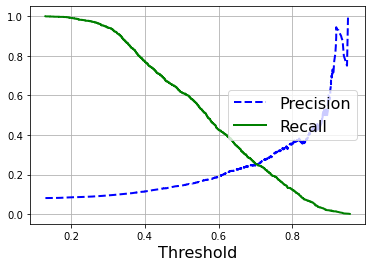

In [36]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)


# save the figure as this results in a better quality compared to a screenshot
plt.savefig('precision_recall.png')
plt.savefig('precision_recall.eps', format='eps', transparent=False)

In [37]:
predictions = logistic_regression.predict(validation_features)
# Calculate the accuracy and recall 

accuracy=accuracy_score(validation_label, predictions)
recall = recall_score(validation_label, predictions)
precision=precision_score(validation_label, predictions)

print("Logistic Regression Result:")
print("accuracy:", accuracy)
print("recall:", recall)
print("precision:",precision)

#calculate F1,F2,F0.5
f1_lr = f1_score(validation_label, predictions)
f2_lr= fbeta_score(validation_label, predictions, beta=2)
f05_lr= fbeta_score(validation_label, predictions, beta=0.5)

print("F1 score:",f1_lr)
print("F2 score:",f2_lr)
print("F0.5 score:",f05_lr)

Logistic Regression Result:
accuracy: 0.6735367948209803
recall: 0.6151960784313726
precision: 0.14414241960183768
F1 score: 0.233560794044665
F2 score: 0.37203557312252966
F0.5 score: 0.17020795660036167


In [38]:
#overfiting check
from sklearn import metrics
print('Training Accuracy : ',metrics.accuracy_score(train_label_oversampled,logistic_regression.predict(train_features_oversampled))*100)
print('Validation Accuracy : ',metrics.accuracy_score(validation_label,logistic_regression.predict(validation_features))*100)

Training Accuracy :  65.39332303158803
Validation Accuracy :  67.35367948209803


Feature: distance, 0, Score: 0.15410
Feature: product_size_cm3, 1, Score: -0.01573
Feature: product_weight_g, 2, Score: 0.11014
Feature: number_order_in_process, 3, Score: 0.03424
Feature: tardy_proportion_last_10_orders, 4, Score: 0.38280
Feature: Home and Gardon, 5, Score: 0.05978
Feature: Electronics and Gadgets, 6, Score: 0.02768
Feature: Beauty and Personal Care, 7, Score: 0.04391
Feature: Sports and Outdoors, 8, Score: 0.05557
Feature: Fashion, Apparel and Luggage, 9, Score: 0.17056
Feature: Baby and Toys, 10, Score: -0.11285
Feature: Business, Industrial and Scientific Supplies, 11, Score: -0.07272
Feature: Automotive and Parts, 12, Score: -0.02168
Feature: Home Appliances, 13, Score: -0.06800
Feature: Pet, 14, Score: -0.12784
Feature: Books and Media, 15, Score: -0.03557
Feature: Food and Beverages, 16, Score: -0.10393
Feature: Musical Instruments, 17, Score: 0.25608
Feature: Arts and Crafts, 18, Score: 0.04801
Feature: Decoration, 19, Score: -0.22455
Feature: Network and Secur

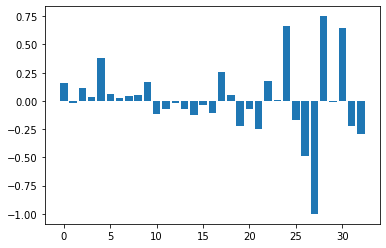

In [39]:
#feature importance
feature_names = ['distance','product_size_cm3','product_weight_g','number_order_in_process','tardy_proportion_last_10_orders','Home and Gardon','Electronics and Gadgets',
                 'Beauty and Personal Care','Sports and Outdoors','Fashion, Apparel and Luggage','Baby and Toys',
                 'Business, Industrial and Scientific Supplies','Automotive and Parts','Home Appliances','Pet',
                'Books and Media','Food and Beverages','Musical Instruments','Arts and Crafts','Decoration',
                 'Network and Security Service','August','May','July','March','June','April','February','January',
                 'November','December','October','September']
importance_lr = logistic_regression.coef_[0]
# summarize feature importance
for i,v in enumerate(importance_lr):
 print('Feature: %s, %0d, Score: %.5f' % (feature_names[i], i , v))
# plot feature importance
plt.bar([x for x in range(len(importance_lr))], importance_lr)
plt.show()

# Random Forest

In [40]:
# create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=12)

# fit the random forest to the training data
rf.fit(train_features_oversampled,train_label_oversampled)

# calculate the predicted probabilities for the test data
y_scores = rf.predict_proba(validation_features)[:, 1]

# calculate the precision, recall, and threshold values
precision2, recall2, threshold2 = precision_recall_curve(validation_label, y_scores)

# print the precision, recall, and threshold values
#print("Precision:", precision)
#print("Recall:", recall)
#print("Threshold:", threshold)

In [41]:
#overfiting check
print('Training Accuracy : ',metrics.accuracy_score(train_label_oversampled,rf.predict(train_features_oversampled))*100)
print('Validation Accuracy : ',metrics.accuracy_score(validation_label,rf.predict(validation_features))*100)

Training Accuracy :  76.3008948143889
Validation Accuracy :  75.90170432025367


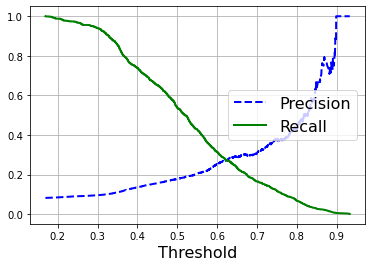

In [42]:
plt.plot(threshold2, precision2[:-1], "b--", label="Precision", linewidth=2)
plt.plot(threshold2, recall2[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)

In [43]:
predictions = rf.predict(validation_features)
# Calculate the accuracy and recall 
accuracy2=accuracy_score(validation_label, predictions)
recall2 = recall_score(validation_label, predictions)
precision2=precision_score(validation_label, predictions)

print("Random Forest Result:")
print("accuracy:", accuracy2)
print("recall:", recall2)
print("precision:",precision2)

Random Forest Result:
accuracy: 0.7590170432025367
recall: 0.5392156862745098
precision: 0.1762820512820513


Feature: distance, 0, Score: 0.17993
Feature: product_size_cm3, 1, Score: 0.07931
Feature: product_weight_g, 2, Score: 0.07557
Feature: number_order_in_process, 3, Score: 0.07776
Feature: tardy_proportion_last_10_orders, 4, Score: 0.23200
Feature: Home and Gardon, 5, Score: 0.00084
Feature: Electronics and Gadgets, 6, Score: 0.00376
Feature: Beauty and Personal Care, 7, Score: 0.00426
Feature: Sports and Outdoors, 8, Score: 0.00612
Feature: Fashion, Apparel and Luggage, 9, Score: 0.00206
Feature: Baby and Toys, 10, Score: 0.00552
Feature: Business, Industrial and Scientific Supplies, 11, Score: 0.00130
Feature: Automotive and Parts, 12, Score: 0.00490
Feature: Home Appliances, 13, Score: 0.00488
Feature: Pet, 14, Score: 0.00164
Feature: Books and Media, 15, Score: 0.00382
Feature: Food and Beverages, 16, Score: 0.00596
Feature: Musical Instruments, 17, Score: 0.00192
Feature: Arts and Crafts, 18, Score: 0.00051
Feature: Decoration, 19, Score: 0.00254
Feature: Network and Security Servi

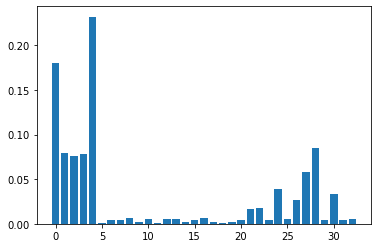

In [44]:
#feature importance
importance_rf = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_rf):
 print('Feature: %s, %0d, Score: %.5f' % (feature_names[i], i, v))
# plot feature importance
plt.bar([x for x in range(len(importance_rf))], importance_rf)
plt.show()

# Decision Tree

In [45]:
dt = DecisionTreeClassifier(random_state=42, max_depth =10, min_samples_leaf=10)
dt.fit(train_features_oversampled,train_label_oversampled)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=42)

In [46]:
dt_scores = dt.predict_proba(validation_features)[:, 1]

dt_precision, dt_recall, dt_threshold = precision_recall_curve(validation_label, dt_scores)

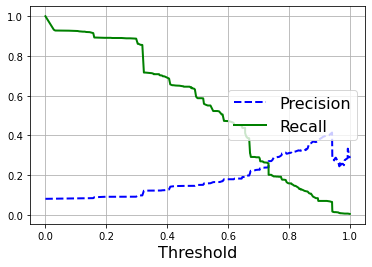

In [47]:
plt.plot(dt_threshold, dt_precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(dt_threshold, dt_recall[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)

In [48]:
predictions = dt.predict(validation_features)
# Calculate the accuracy and recall 
dt_accuracy=accuracy_score(validation_label, predictions)
dt_recall = recall_score(validation_label, predictions)
dt_precision=precision_score(validation_label, predictions)

print("Decision Tree Result:")
print("accuracy:", dt_accuracy)
print("recall:", dt_recall)
print("precision:",dt_precision)

Decision Tree Result:
accuracy: 0.6991676575505351
recall: 0.5874183006535948
precision: 0.1507969798657718


In [49]:
#overfiting check
print('Training Accuracy : ',metrics.accuracy_score(train_label_oversampled,dt.predict(train_features_oversampled))*100)
print('Validation Accuracy : ',metrics.accuracy_score(validation_label,dt.predict(validation_features))*100)

Training Accuracy :  71.24555288029612
Validation Accuracy :  69.91676575505352


Feature: distance, 0, Score: 0.21045
Feature: product_size_cm3, 1, Score: 0.06540
Feature: product_weight_g, 2, Score: 0.06755
Feature: number_order_in_process, 3, Score: 0.03958
Feature: tardy_proportion_last_10_orders, 4, Score: 0.29168
Feature: Home and Gardon, 5, Score: 0.00000
Feature: Electronics and Gadgets, 6, Score: 0.00109
Feature: Beauty and Personal Care, 7, Score: 0.00532
Feature: Sports and Outdoors, 8, Score: 0.00263
Feature: Fashion, Apparel and Luggage, 9, Score: 0.00016
Feature: Baby and Toys, 10, Score: 0.00553
Feature: Business, Industrial and Scientific Supplies, 11, Score: 0.00118
Feature: Automotive and Parts, 12, Score: 0.00412
Feature: Home Appliances, 13, Score: 0.00646
Feature: Pet, 14, Score: 0.00043
Feature: Books and Media, 15, Score: 0.00000
Feature: Food and Beverages, 16, Score: 0.00417
Feature: Musical Instruments, 17, Score: 0.00000
Feature: Arts and Crafts, 18, Score: 0.00000
Feature: Decoration, 19, Score: 0.00000
Feature: Network and Security Servi

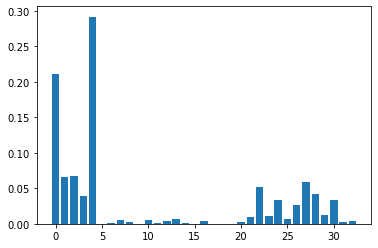

In [50]:
#featrue importance
import matplotlib.pyplot as plt
importance_dt = dt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_dt):
  print('Feature: %s, %0d, Score: %.5f' % (feature_names[i], i, v))
# plot feature importance
plt.bar([x for x in range(len(importance_dt))], importance_dt)
plt.show()


# Hyper-parameter optimisation (may take some minutes to run)

In [51]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from collections import Counter

# Define the hyperparameters to tune
param_dist = {
    'learning_rate':np.arange(0.05,0.3,0.05),
    'n_estimators': range(0, 500, 20),
    'max_depth': range(1, 10),
    'min_child_weight': range(1, 21),
    'subsample': np.arange(0.1, 1.0, 0.1),
    'colsample_bytree': np.arange(0.1, 1.1, 0.1),
    'scale_pos_weight': np.arange(1, 6, 0.5),
    'gamma':np.arange(0,5,0.5)
}

# Define the number of folds
n_splits = 5

# Define the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize an empty list to store the best hyperparameters
best_params = []

# Loop over the folds
for i, (train_idx, val_idx) in enumerate(skf.split(data_prepared, data_label)):
    print(f'Fold {i+1}:')
    print(f'Train indices: {train_idx}')
    print(f'Train index values: {data_label.index[train_idx]}')
    print(f'Validation indices: {val_idx}')
    
    # Split data into train and validation sets
    X_train, y_train = data_prepared[train_idx], data_label.iloc[train_idx]
    X_val, y_val = data_prepared[val_idx], data_label.iloc[val_idx]
    
    # Oversample training data
    ros = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)
        
    # Define the XGBoost model
    xgb_classifier = xgb.XGBClassifier(random_state=42)
    
    # Define the search object
    search_xgb = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist, cv=4, n_jobs=-1, scoring='recall')
    
    # Fit the search object to the oversampled training data
    search_xgb.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict on the validation data using the non-oversampled model
    y_pred = search_xgb.predict(X_val)
     
    val_recall = recall_score(y_val, y_pred)
    print(f'Validation recall: {val_recall}')
    
    # Save best hyperparameters
    best_params.append(search_xgb.best_params_)

# Count the occurrence of each parameter combination
best_params_count = Counter(tuple(sorted(d.items())) for d in best_params)

# Print the best hyperparameters
print(f'Best hyperparameters: {dict(best_params_count.most_common(1)[0][0])}')

Fold 1:
Train indices: [    0     1     2 ... 75684 75686 75688]
Train index values: Int64Index([17465, 65781,  6551, 65081, 33940,  4173, 31386, 44860, 59017,
            60098,
            ...
            46365, 30265, 46854, 47827, 33129, 33839, 14622,  8238, 46254,
            62314],
           dtype='int64', length=60552)
Validation indices: [    4    11    17 ... 75685 75687 75689]


/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

[13:32:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation recall: 0.7173202614379085
Fold 2:
Train indices: [    0     4     8 ... 75686 75687 75689]
Train index values: Int64Index([17465, 54220, 44860, 59017, 60098, 23489, 86434, 91557, 36110,
            77695,
            ...
            47827, 49346, 33839, 14622, 86688,  8238, 44284, 46254, 76529,
            50905],
           dtype='int64', length=60552)
Validation indices: [    1     2     3 ... 75666 75680 75688]


/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:38:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation recall: 0.47549019607843135
Fold 3:
Train indices: [    0     1     2 ... 75687 75688 75689]
Train index values: Int64Index([17465, 65781,  6551, 65081, 54220, 33940,  4173, 31386, 44860,
            60098,
            ...
            49346, 33129, 33839, 14622, 86688, 44284, 46254, 76529, 62314,
            50905],
           dtype='int64', length=60552)
Validation indices: [    9    14    16 ... 75667 75678 75684]


/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

[13:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation recall: 0.8578431372549019
Fold 4:
Train indices: [    1     2     3 ... 75687 75688 75689]
Train index values: Int64Index([65781,  6551, 65081, 54220, 33940,  4173, 31386, 44860, 59017,
            23489,
            ...
            47827, 49346, 33129, 33839, 86688,  8238, 44284, 76529, 62314,
            50905],
           dtype='int64', length=60552)
Validation indices: [    0    10    15 ... 75668 75682 75686]


/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

[13:48:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation recall: 0.6873469387755102
Fold 5:
Train indices: [    0     1     2 ... 75687 75688 75689]
Train index values: Int64Index([17465, 65781,  6551, 65081, 54220, 33940,  4173, 31386, 59017,
            60098,
            ...
            49346, 33129, 14622, 86688,  8238, 44284, 46254, 76529, 62314,
            50905],
           dtype='int64', length=60552)
Validation indices: [    8    12    13 ... 75676 75677 75681]


/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-p

[13:55:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation recall: 0.9991836734693877
Best hyperparameters: {'colsample_bytree': 1.0, 'gamma': 4.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 340, 'scale_pos_weight': 4.5, 'subsample': 0.30000000000000004}


# Evaluation of the final model

In [52]:
#5 folds parameters
best_xgb_classifier = xgb.XGBClassifier(colsample_bytree=1,gamma= 4, 
                                        learning_rate=0.2, max_depth= 6, 
                                        min_child_weight= 5, n_estimators= 340,
                                        scale_pos_weight= 4.5, subsample=0.3 ,random_state=42)
data_features_test_prepared = full_pipeline.transform(data_features_test)
#my code:learning_rate=0.25, max_depth= 3, scale_pos_weight= 5.5, subsample=0.7 ,random_state=42
#mechelle code ：learning_rate=0.2, max_depth= 9,scale_pos_weight= 3, subsample=0.4 
# Fit the XGBoost model on the entire training set
best_xgb_classifier.fit(train_features_oversampled, train_label_oversampled)

# Use the fitted XGBoost model to predict the target variable on the test set
test_predictions = best_xgb_classifier.predict(data_features_test_prepared)

[13:55:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [53]:
print('result after hyperparameter')
print('Training Accuracy : ',accuracy_score(train_label_oversampled,best_xgb_classifier.predict(train_features_oversampled)))
print('Training Recall : ',recall_score(train_label_oversampled,best_xgb_classifier.predict(train_features_oversampled)))
print('Training Precision : ',precision_score(train_label_oversampled,best_xgb_classifier.predict(train_features_oversampled)))

print('Validation Accuracy : ',accuracy_score(validation_label,best_xgb_classifier.predict(validation_features)))
print('Validation Recall : ',recall_score(validation_label,best_xgb_classifier.predict(validation_features)))
print('Validation Precision : ',precision_score(validation_label,best_xgb_classifier.predict(validation_features)))
      
print("Result among test data:")
print("test accuracy:", accuracy_score(data_label_test, best_xgb_classifier.predict(data_features_test_prepared)))
print("test recall:", recall_score(data_label_test, best_xgb_classifier.predict(data_features_test_prepared)))
print("test precision:",precision_score(data_label_test, best_xgb_classifier.predict(data_features_test_prepared)))

result after hyperparameter
Training Accuracy :  0.8013709706400258
Training Recall :  0.9992633054227908
Training Precision :  0.7159150886317117
Validation Accuracy :  0.5823754789272031
Validation Recall :  0.696078431372549
Validation Precision :  0.12525727727139077
Result among test data:
test accuracy: 0.5750673783226761
test recall: 0.7099934683213586
test precision: 0.12517273146015662


In [54]:
final_scores = best_xgb_classifier.predict_proba(data_features_test_prepared)[:, 1]

final_precision, final_recall, final_threshold = precision_recall_curve(data_label_test, final_scores)

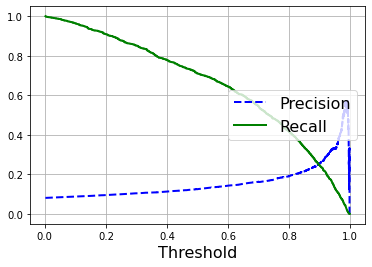

In [55]:
plt.plot(final_threshold, final_precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(final_threshold, final_recall[:-1], "g-", label="Recall", linewidth=2)
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16) 
plt.grid(True)

confusion matrix

In [56]:
conf_mat = confusion_matrix(data_label_test, test_predictions)
print(conf_mat)

[[9795 7597]
 [ 444 1087]]


In [57]:
conf_mat_normalised = conf_mat / conf_mat.sum(axis=1, keepdims=True)

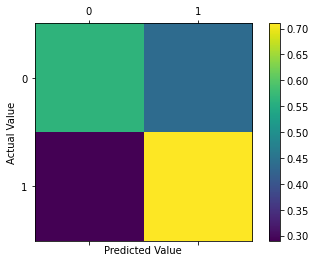

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_normalised)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
fig.colorbar(cax)

# save the figure as this results in a better quality compared to a screenshot
plt.savefig('confusion_matrix.png') # pixel graphic: easier to use in Word
plt.savefig('confusion_matrix.eps') # vector graphic: best quality

# Some notes: 
# To highlight the off-diagonal values, replace the matrix by
#  onf_mat_normalised - np.diag(np.diag(conf_mat_normalised))
# When a gray-scale image is required add
#  cmap='gray'
# to the arguments of ax.matshow

ROC curve

In [59]:
best_xgb_classifier.probability = True
# New fit, to compute scores:
best_xgb_classifier.fit(data_features_test_prepared, data_label_test)

/Users/andrew.tseng/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=4, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=340, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.5, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

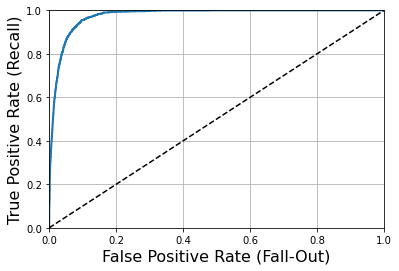

In [60]:
final_predictions_scores = best_xgb_classifier.predict_proba(data_features_test_prepared)[:,1]
fpr, tpr, thresholds = roc_curve(data_label_test, final_predictions_scores)


plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.grid(True)

# save the figure as this results in a better quality compared to a screenshot
plt.savefig('roc.png')
plt.savefig('roc.eps')

In [61]:
print(roc_auc_score(data_label_test,final_predictions_scores))

0.9752833498678342


In [62]:
predictions = best_xgb_classifier.predict(data_features_test_prepared)
# Calculate the accuracy and recall 
accuracy2=accuracy_score(data_label_test, predictions)
recall2 = recall_score(data_label_test, predictions)
precision2=precision_score(data_label_test, predictions)

print("final_model_result:")
print("accuracy:", accuracy2)
print("recall:", recall2)
print("precision:",precision2)

final_model_result:
accuracy: 0.9480526343603023
recall: 0.8092749836708034
precision: 0.6419689119170985


Feature: 0, Score: 0.03235
Feature: 1, Score: 0.03152
Feature: 2, Score: 0.03120
Feature: 3, Score: 0.02998
Feature: 4, Score: 0.03730
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.03162
Feature: 7, Score: 0.03044
Feature: 8, Score: 0.03028
Feature: 9, Score: 0.03547
Feature: 10, Score: 0.03041
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.02680
Feature: 13, Score: 0.03064
Feature: 14, Score: 0.03328
Feature: 15, Score: 0.03440
Feature: 16, Score: 0.02622
Feature: 17, Score: 0.03822
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.03542
Feature: 20, Score: 0.03084
Feature: 21, Score: 0.03516
Feature: 22, Score: 0.03630
Feature: 23, Score: 0.02903
Feature: 24, Score: 0.03283
Feature: 25, Score: 0.03534
Feature: 26, Score: 0.03483
Feature: 27, Score: 0.04676
Feature: 28, Score: 0.03603
Feature: 29, Score: 0.03062
Feature: 30, Score: 0.03892
Feature: 31, Score: 0.03450
Feature: 32, Score: 0.03328


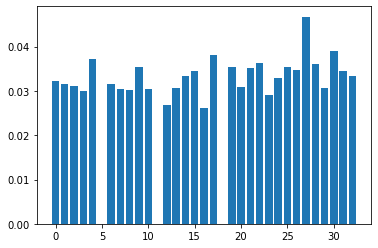

[13:27:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:49] WARNING: /Users/runner/miniforge3/cond

[13:27:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:20] WARNING: /Users/runner/miniforge3/cond

[13:27:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:49] WARNING: /Users/runner/miniforge3/cond

[13:27:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:18] WARNING: /Users/runner/miniforge3/cond

In [63]:
#featrue importance
import matplotlib.pyplot as plt
importance_final = best_xgb_classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_final):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_final))], importance_final)
plt.show()